
# 🧠 Interpretable Inventory Forecasting — LightGBM (End-to-End, Robust v2)

This notebook builds an **interpretable inventory forecasting framework** focused on **LightGBM** for small retail businesses using your dataset: `retail_store_inventory.csv`.

**Pipeline:** Data Preprocessing → EDA → Feature Engineering → Model (LightGBM) + Tuning → Evaluation → SHAP → Save Artifacts.

**Metrics:** MAE, RMSE, MAPE, R²  
**Explainability:** SHAP (summary bar + dot)


In [ ]:

# Optional installs (uncomment if needed)
# !pip install lightgbm shap scikit-learn pandas numpy matplotlib joblib


In [ ]:

import os, json, math, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from typing import List, Optional

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

from lightgbm import LGBMRegressor
import shap

from google.colab import drive
drive.mount('/content/drive/')


# ---------------- Configuration (explicit to your dataset) ----------------
# Primary path: same directory as this notebook
DATA_PATH = '/content/drive/MyDrive/data/retail_store_inventory.csv'


# Explicitly set correct target/date for your schema
TARGET_CANDIDATES = ['Units Sold']        # change to ['Demand Forecast'] if desired
DATE_CANDIDATES   = ['Date']

# Lag/rolling params
LAGS = [1, 7, 14, 28]
ROLLING_WINDOWS = [7, 14, 28]

# Grouping keys for per-store-product lags (auto-detects from these)
GROUP_KEYS_CANDIDATES = [
    ['Store ID', 'Product ID'],
    ['Store ID'], ['Product ID']
]

RANDOM_STATE = 42
N_JOBS = -1

SAVE_DIR = 'artifacts_lightgbm_v2'
os.makedirs(SAVE_DIR, exist_ok=True)
print(f'Artifacts will be saved to: {SAVE_DIR}')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Artifacts will be saved to: artifacts_lightgbm_v2


In [ ]:

def smart_find_column(candidates: List[str], columns: List[str]) -> Optional[str]:
    lower_map = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    return None

def detect_target_and_date(df: pd.DataFrame):
    target = smart_find_column(TARGET_CANDIDATES, df.columns.tolist())
    date_col = smart_find_column(DATE_CANDIDATES, df.columns.tolist())
    if target is None:
        raise KeyError(f"""Could not detect target column.
Tried {TARGET_CANDIDATES}.
Available columns: {df.columns.tolist()}
Please rename/adjust TARGET_CANDIDATES and re-run.""")
    if date_col is None:
        print("[WARN] No explicit date column found. Proceeding without calendar features.")
    return target, date_col

def add_date_parts(df, date_col):
    if date_col is None:
        return df
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(date_col)
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['weekofyear'] = df[date_col].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    return df

def best_group_keys(df):
    for keys in GROUP_KEYS_CANDIDATES:
        if all(k in df.columns for k in keys):
            return keys
    return None

def add_lag_rolling(df, target, date_col):
    df = df.copy()
    keys = best_group_keys(df)
    if date_col:
        df = df.sort_values(date_col)
    if keys:
        order_cols = keys + ([date_col] if date_col else [])
        df = df.sort_values(order_cols)
        gb = df.groupby(keys, group_keys=False)
        for lag in LAGS:
            df[f'lag_{lag}'] = gb[target].shift(lag)
        for win in ROLLING_WINDOWS:
            df[f'roll_mean_{win}'] = gb[target].shift(1).rolling(window=win, min_periods=1).mean()
            df[f'roll_std_{win}']  = gb[target].shift(1).rolling(window=win, min_periods=1).std()
    else:
        for lag in LAGS:
            df[f'lag_{lag}'] = df[target].shift(lag)
        for win in ROLLING_WINDOWS:
            df[f'roll_mean_{win}'] = df[target].shift(1).rolling(window=win, min_periods=1).mean()
            df[f'roll_std_{win}']  = df[target].shift(1).rolling(window=win, min_periods=1).std()
    return df

def time_based_train_test_split(df, date_col, test_size=0.2):
    n = len(df)
    split_idx = int((1 - test_size) * n)
    if date_col:
        df = df.sort_values(date_col)
    train_df = df.iloc[:split_idx].copy()
    test_df  = df.iloc[split_idx:].copy()
    return train_df, test_df

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mp = mape(y_true, y_pred)
    return {'MAE': float(mae), 'RMSE': float(rmse), 'MAPE': float(mp), 'R2': float(r2)}


## 1) Load & Inspect Data

In [ ]:

assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Place 'retail_store_inventory.csv' next to this notebook or under /mnt/data."
df_raw = pd.read_csv(DATA_PATH)
print(f"Loaded shape: {df_raw.shape}")
display(df_raw.head(3))
print(df_raw.dtypes)


Loaded shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer


Date                   object
Store ID               object
Product ID             object
Category               object
Region                 object
Inventory Level         int64
Units Sold              int64
Units Ordered           int64
Demand Forecast       float64
Price                 float64
Discount                int64
Weather Condition      object
Holiday/Promotion       int64
Competitor Pricing    float64
Seasonality            object
dtype: object


## 2) Detect Target/Date, Clean & Prepare

In [ ]:

# Detect columns
target, date_col = detect_target_and_date(df_raw)
print(f"Detected target: {target}")
print(f"Detected date: {date_col}")

df = df_raw.copy()

# Clean target/date
if df[target].isna().any():
    print(f"[INFO] Dropping rows with NA in target '{target}'.")
    df = df[~df[target].isna()].copy()

if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    bad = df[date_col].isna().sum()
    if bad > 0:
        print(f"[INFO] Dropping {bad} rows with invalid dates in '{date_col}'.")
        df = df[~df[date_col].isna()].copy()

print(f"Post-clean shape: {df.shape}")


Detected target: Units Sold
Detected date: Date
Post-clean shape: (73100, 15)


## 3) Quick EDA (Robust)

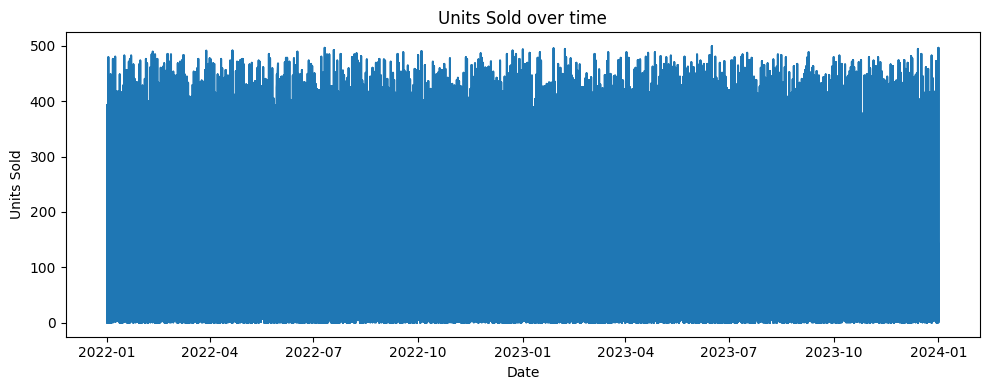

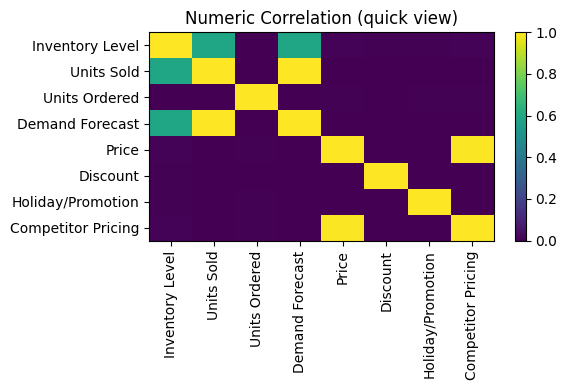

In [ ]:

# --- Safety: ensure `target` and `date_col` exist even if you ran cells out of order ---
if 'target' not in locals() or 'date_col' not in locals():
    target = smart_find_column(TARGET_CANDIDATES, df.columns.tolist())
    date_col = smart_find_column(DATE_CANDIDATES, df.columns.tolist())
    print(f"[Safety init] target={target}, date_col={date_col}")

# Line plot over time if date exists
if date_col:
    df_sorted = df.sort_values(date_col)
    plt.figure(figsize=(10,4))
    plt.plot(df_sorted[date_col], df_sorted[target])
    plt.title(f'{target} over time')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

# Quick numeric correlation heatmap
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,4))
    plt.imshow(corr, aspect='auto')
    plt.colorbar()
    plt.title('Numeric Correlation (quick view)')
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.show()


## 4) Feature Engineering

In [ ]:

df_fe = add_date_parts(df, date_col)
df_fe = add_lag_rolling(df_fe, target, date_col)

# Optional engineered interactions
if 'Price' in df_fe.columns and 'Discount' in df_fe.columns:
    df_fe['effective_price'] = df_fe['Price'] * (1 - df_fe['Discount'].clip(0, 1))
if 'Competitor Pricing' in df_fe.columns and 'Price' in df_fe.columns:
    df_fe['price_competitor_gap'] = df_fe['Price'] - df_fe['Competitor Pricing']
if 'Holiday/Promotion' in df_fe.columns:
    # normalize to int 0/1 if possible
    try:
        df_fe['Holiday/Promotion'] = df_fe['Holiday/Promotion'].astype(int)
    except Exception:
        pass

# Drop early rows with NA from lags
lag_cols = [c for c in df_fe.columns if c.startswith('lag_')]
before = len(df_fe)
df_fe = df_fe.dropna(subset=lag_cols, how='any') if lag_cols else df_fe
after = len(df_fe)
print(f"Dropped {before - after} rows due to lag feature NA (if any).")


print(f"Engineered shape: {df_fe.shape}")
display(df_fe.head(3))


Dropped 2800 rows due to lag feature NA (if any).
Engineered shape: (70300, 33)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,lag_14,lag_28,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_28,roll_std_28,effective_price,price_competitor_gap
2800,2022-01-29,S001,P0001,Furniture,South,154,47,124,48.79,88.06,...,176.0,127.0,111.142857,71.601742,137.357143,94.555321,116.071429,93.539823,0.00,-4.78
2900,2022-01-30,S001,P0001,Furniture,West,498,130,63,148.26,68.76,...,97.0,81.0,90.571429,65.237661,128.142857,96.759700,113.214286,94.411376,0.00,-4.53
3000,2022-01-31,S001,P0001,Clothing,West,410,200,152,212.24,70.78,...,69.0,5.0,97.857143,66.564326,130.500000,96.343736,114.964286,94.246125,70.78,1.90


## 5) Train / Test Split (Time-based)

In [ ]:

train_df, test_df = time_based_train_test_split(df_fe, date_col, test_size=0.2)
print(train_df.shape, test_df.shape)

drop_cols = [target] + ([date_col] if date_col else [])
X_train = train_df.drop(columns=drop_cols, errors='ignore')
y_train = train_df[target].values
X_test  = test_df.drop(columns=drop_cols, errors='ignore')
y_test  = test_df[target].values

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]
print(f"Numeric features: {len(numeric_features)} | Categorical features: {len(categorical_features)}")


(56240, 33) (14060, 33)
Numeric features: 25 | Categorical features: 6


## 6) Pipeline: Preprocess → LightGBM + GridSearchCV

In [ ]:

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)],
    remainder='drop'
)

lgbm = LGBMRegressor(
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    objective='mae'
)

pipe = Pipeline(steps=[('prep', preprocessor), ('reg', lgbm)])

# ~16 combos → 3-fold TSS → ~48 fits
param_grid = {
    'reg__num_leaves': [31, 63],
    'reg__learning_rate': [0.05, 0.1],
    'reg__n_estimators': [200, 400],
    'reg__min_child_samples': [20],
    'reg__subsample': [0.8],
    'reg__colsample_bytree': [0.8, 1.0],
}

tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=N_JOBS,
    verbose=1
)

grid.fit(X_train, y_train)
print(f"Best params: {grid.best_params_}")
print(f"Best CV MAE: {-grid.best_score_:.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4458
[LightGBM] [Info] Number of data points in the train set: 56240, number of used features: 67
[LightGBM] [Info] Start training from score 108.000000
Best params: {'reg__colsample_bytree': 1.0, 'reg__learning_rate': 0.05, 'reg__min_child_samples': 20, 'reg__n_estimators': 200, 'reg__num_leaves': 31, 'reg__subsample': 0.8}
Best CV MAE: 7.2621


## 7) Evaluation on Hold-out Test

{
  "MAE": 7.259919237087725,
  "RMSE": 8.49912042747147,
  "MAPE": 20.18634197298445,
  "R2": 0.9938250128532237
}


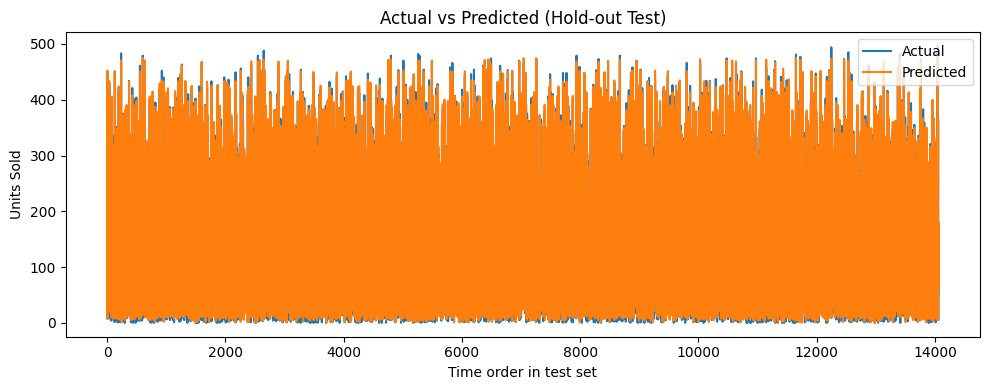

Saved model pipeline.


In [ ]:

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

def evaluate_print_save(y_true, y_pred, save_dir):
    metrics = {
        'MAE': float(mean_absolute_error(y_true, y_pred)),
        'RMSE': float(math.sqrt(mean_squared_error(y_true, y_pred))),
        'MAPE': float(mape(y_true, y_pred)),
        'R2': float(r2_score(y_true, y_pred))
    }
    print(json.dumps(metrics, indent=2))
    with open(os.path.join(save_dir, 'test_metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=2)
    return metrics

metrics = evaluate_print_save(y_test, y_pred, SAVE_DIR)

plt.figure(figsize=(10,4))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.title('Actual vs Predicted (Hold-out Test)')
plt.xlabel('Time order in test set')
plt.ylabel(target)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'actual_vs_pred.png'), dpi=160, bbox_inches='tight')
plt.show()

joblib.dump(best_model, os.path.join(SAVE_DIR, 'lightgbm_pipeline.joblib'))
print('Saved model pipeline.')


## 8) Explainability with SHAP

In [ ]:

best_model = grid.best_estimator_
prep = best_model.named_steps['prep']
reg  = best_model.named_steps['reg']

# Fit preprocessor on train to align feature names
prep_fitted = prep.fit(X_train, y_train)

def get_feature_names(column_transformer, input_features):
    try:
        return column_transformer.get_feature_names_out(input_features).tolist()
    except Exception:
        output_features = []
        for name, trans, cols in column_transformer.transformers_:
            if name == 'remainder':
                continue
            if hasattr(trans, 'get_feature_names_out'):
                try:
                    names = trans.get_feature_names_out(cols)
                except Exception:
                    names = cols
            else:
                names = cols
            output_features.extend(list(names))
        return output_features

Xtr_enc = prep_fitted.transform(X_train)
feature_names = get_feature_names(prep_fitted, X_train.columns)

# SHAP
explainer = shap.TreeExplainer(reg)
bg_size = min(100, Xtr_enc.shape[0])
shap_values = explainer.shap_values(Xtr_enc[:bg_size])

plt.figure()
shap.summary_plot(shap_values, features=Xtr_enc[:bg_size], feature_names=feature_names, show=False, plot_type='bar')
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'shap_summary_bar.png'), dpi=160, bbox_inches='tight')
plt.close()

plt.figure()
shap.summary_plot(shap_values, features=Xtr_enc[:bg_size], feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'shap_summary_dot.png'), dpi=160, bbox_inches='tight')
plt.close()

print('Saved SHAP plots.')


Saved SHAP plots.


## 9) Native LightGBM Feature Importances

In [ ]:

# Optional: native importances on encoded space
reg_fresh = LGBMRegressor(**best_model.named_steps['reg'].get_params())
reg_fresh.fit(Xtr_enc, y_train)
importances = reg_fresh.feature_importances_

imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(25)
imp_df.to_csv(os.path.join(SAVE_DIR, 'top25_feature_importances.csv'), index=False)

plt.figure(figsize=(8,6))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title('Top 25 Encoded Feature Importances (LightGBM)')
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'lgbm_feature_importances_top25.png'), dpi=160, bbox_inches='tight')
plt.close()

print('Saved feature importance chart and CSV.')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4458
[LightGBM] [Info] Number of data points in the train set: 56240, number of used features: 67
[LightGBM] [Info] Start training from score 108.000000
Saved feature importance chart and CSV.


## 10) Save Metadata & Params

In [ ]:

meta = {
    'target': target,
    'date_col': date_col,
    'numeric_features': [c for c in X_train.columns if c not in [*X_train.select_dtypes(exclude=[np.number]).columns]],
    'categorical_features': [c for c in X_train.columns if c in X_train.select_dtypes(exclude=[np.number]).columns],
    'lags': LAGS,
    'rolling_windows': ROLLING_WINDOWS,
    'best_params': grid.best_params_,
    'save_dir': SAVE_DIR,
    'created_at': datetime.now().isoformat()
}
with open(os.path.join(SAVE_DIR, 'metadata.json'), 'w') as f:
    json.dump(meta, f, indent=2)
print('Saved metadata.')


Saved metadata.



### ✅ Notes
- To forecast **demand** instead of sales, set `TARGET_CANDIDATES = ['Demand Forecast']` at the top and rerun.
- If you add external data (holidays, weather, competitor), merge it **before** feature engineering.
- If GridSearch is heavy, reduce `n_estimators` or n_splits, or shrink the grid.
